<a name='1'></a>
## 1 - Packages

Go ahead and run the cell below to import the packages you'll need.

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Lambda, Flatten, Dense
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K
K.set_image_data_format('channels_last')
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
import PIL

%matplotlib inline
%load_ext autoreload
%autoreload 2

2023-06-12 16:13:00.832516: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2023-06-12 16:13:00.832533: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
from tensorflow.keras.models import model_from_json

json_file = open('keras-facenet-h5/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights('keras-facenet-h5/model.h5')

2023-06-12 16:13:02.023836: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2023-06-12 16:13:02.049389: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-12 16:13:02.049497: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1650 Ti computeCapability: 7.5
coreClock: 1.485GHz coreCount: 16 deviceMemorySize: 3.80GiB deviceMemoryBandwidth: 178.84GiB/s
2023-06-12 16:13:02.049560: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2023-06-12 16:13:02.049598: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic li

In [3]:
print(model.inputs)
print(model.outputs)

[<tf.Tensor 'input_1:0' shape=(None, 160, 160, 3) dtype=float32>]
[<tf.Tensor 'Bottleneck_BatchNorm/batchnorm/add_1:0' shape=(None, 128) dtype=float32>]


In [4]:
model.summary()

Model: "inception_resnet_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
________________________________________________________________________________

In [5]:
# GRADED FUNCTION: triplet_loss

def triplet_loss(y_true, y_pred, alpha = 0.2):
    """
    Implementation of the triplet loss as defined by formula (3)
    
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor images, of shape (None, 128)
            positive -- the encodings for the positive images, of shape (None, 128)
            negative -- the encodings for the negative images, of shape (None, 128)
    
    Returns:
    loss -- real number, value of the loss
    """
    
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    # YOUR CODE STARTS HERE (≈ 4 lines)
    # Step 1: Compute the (encoding) distance between the anchor and the positive
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,positive)),axis=-1)
    # Step 2: Compute the (encoding) distance between the anchor and the negative
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,negative)),axis=-1)
    # Step 3: subtract the two previous distances and add alpha.
    basic_loss = tf.maximum(tf.add(tf.subtract(pos_dist,neg_dist),alpha),0)
    # Step 4: Take the maximum of basic_loss and 0.0. Sum over the training examples.
    loss = tf.reduce_sum(basic_loss)
    
    # YOUR CODE ENDS HERE
    
    return loss

In [6]:
tf.random.set_seed(1)
y_true = (None, None, None) # It is not used
y_pred = (tf.keras.backend.random_normal([3, 128], mean=6, stddev=0.1, seed = 1),
          tf.keras.backend.random_normal([3, 128], mean=1, stddev=1, seed = 1),
          tf.keras.backend.random_normal([3, 128], mean=3, stddev=4, seed = 1))
loss = triplet_loss(y_true, y_pred)

assert type(loss) == tf.python.framework.ops.EagerTensor, "Use tensorflow functions"
print("loss = " + str(loss))

y_pred_perfect = ([1., 1.], [1., 1.], [1., 1.,])
loss = triplet_loss(y_true, y_pred_perfect, 5)
assert loss == 5, "Wrong value. Did you add the alpha to basic_loss?"
y_pred_perfect = ([1., 1.],[1., 1.], [0., 0.,])
loss = triplet_loss(y_true, y_pred_perfect, 3)
assert loss == 1., "Wrong value. Check that pos_dist = 0 and neg_dist = 2 in this example"
y_pred_perfect = ([1., 1.],[0., 0.], [1., 1.,])
loss = triplet_loss(y_true, y_pred_perfect, 0)
assert loss == 2., "Wrong value. Check that pos_dist = 2 and neg_dist = 0 in this example"
y_pred_perfect = ([0., 0.],[0., 0.], [0., 0.,])
loss = triplet_loss(y_true, y_pred_perfect, -2)
assert loss == 0, "Wrong value. Are you taking the maximum between basic_loss and 0?"
y_pred_perfect = ([[1., 0.], [1., 0.]],[[1., 0.], [1., 0.]], [[0., 1.], [0., 1.]])
loss = triplet_loss(y_true, y_pred_perfect, 3)
assert loss == 2., "Wrong value. Are you applying tf.reduce_sum to get the loss?"


loss = tf.Tensor(527.2598, shape=(), dtype=float32)


**Expected Output**:

<table>
    <tr>
        <td>
            <b>loss</b>
        </td>
        <td>
           527.2598
        </td>
    </tr>
    </table>

In [7]:
FRmodel = model

In [8]:
#tf.keras.backend.set_image_data_format('channels_last')
def img_to_encoding(image_path, model):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(160, 160))
    img = np.around(np.array(img) / 255.0, decimals=12)
    x_train = np.expand_dims(img, axis=0)
    embedding = model.predict_on_batch(x_train)
    return embedding / np.linalg.norm(embedding, ord=2)

In [9]:
import PIL

In [11]:
database = {}
database["smith"] = img_to_encoding("images/steve-smith-mcg.jpg", FRmodel)
database["steve"] = img_to_encoding("images/steve-smith-sixers.jpg", FRmodel)
database["cummins"] = img_to_encoding("images/pat-cummins.jpg", FRmodel)


Load the images of Danielle and Kian: 

In [12]:
steve = tf.keras.preprocessing.image.load_img("images/steve-smith-mcg.jpg", target_size=(160, 160))
cummins = tf.keras.preprocessing.image.load_img("images/pat-cummins.jpg", target_size=(160, 160))

In [13]:
#np.around(np.array(kian) / 255.0, decimals=12).shape

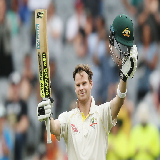

In [15]:
steve

In [18]:
smith = tf.keras.preprocessing.image.load_img("images/steve-smith-mcg.jpg", target_size=(160, 160))
np.around(np.array(smith) / 255.0, decimals=12).shape

(160, 160, 3)

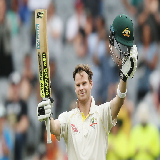

In [19]:
smith

In [20]:
np.around(np.array(steve) / 255.0, decimals=12).shape

(160, 160, 3)

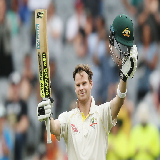

In [21]:
steve

In [22]:
# GRADED FUNCTION: verify

def verify(image_path, identity, database, model):
    """
    Function that verifies if the person on the "image_path" image is "identity".
    
    Arguments:
        image_path -- path to an image
        identity -- string, name of the person you'd like to verify the identity. Has to be an employee who works in the office.
        database -- python dictionary mapping names of allowed people's names (strings) to their encodings (vectors).
        model -- your Inception model instance in Keras
    
    Returns:
        dist -- distance between the image_path and the image of "identity" in the database.
        door_open -- True, if the door should open. False otherwise.
    """
        
    # YOUR CODE STARTS HERE
    
    #Step 1: Compute the encoding for the image. Use img_to_encoding() see example above. (≈ 1 line)
    encoding = img_to_encoding(image_path,model)
    # Step 2: Compute distance with identity's image (≈ 1 line)
    dist = np.linalg.norm(encoding - database[identity])
    # Step 3: Open the door if dist < 0.7, else don't open (≈ 3 lines)
    if dist < 0.7:
        print("It's " + str(identity) + ", welcome in!")
        door_open = True
    else:
        print("It's not " + str(identity) + ", please go away")
        door_open = False

    
    # YOUR CODE ENDS HERE
        
    return dist, door_open

In [ ]:
assert(np.allclose(verify("images/camera_1.jpg", "bertrand", database, FRmodel), (0.54364836, True)))
assert(np.allclose(verify("images/camera_3.jpg", "bertrand", database, FRmodel), (0.38616243, True)))
assert(np.allclose(verify("images/camera_1.jpg", "younes", database, FRmodel), (1.3963861, False)))
assert(np.allclose(verify("images/camera_3.jpg", "younes", database, FRmodel), (1.3872949, False)))
verify("images/camera_0.jpg", "younes", database, FRmodel)

In [27]:
verify("images/steve-smith-mcg.jpg", "cummins", database, FRmodel)
verify("images/pat-cummins.jpg", "cummins", database, FRmodel)

It's not cummins, please go away
It's cummins, welcome in!


(0.0, True)

In [28]:
# GRADED FUNCTION: who_is_it

def who_is_it(image_path, database, model):
    """
    Implements face recognition for the office by finding who is the person on the image_path image.
    
    Arguments:
        image_path -- path to an image
        database -- database containing image encodings along with the name of the person on the image
        model -- your Inception model instance in Keras
    
    Returns:
        min_dist -- the minimum distance between image_path encoding and the encodings from the database
        identity -- string, the name prediction for the person on image_path
    """
    # YOUR CODE STARTS HERE
    
    ## Step 1: Compute the target "encoding" for the image. Use img_to_encoding() see example above. ## (≈ 1 line)
    encoding = img_to_encoding(image_path,model)
    
    ## Step 2: Find the closest encoding ##
    # Initialize "min_dist" to a large value, say 100 (≈1 line)
    min_dist = 100
    
    #Loop over the database dictionary's names and encodings.
    for (name, db_enc) in database.items():
        
        # Compute L2 distance between the target "encoding" and the current db_enc from the database. (≈ 1 line)
        dist = np.linalg.norm(encoding - db_enc)

        # If this distance is less than the min_dist, then set min_dist to dist, and identity to name. (≈ 3 lines)
        if dist < min_dist:
            min_dist = dist
            identity = name
    
    # YOUR CODE ENDS HERE
    
    if min_dist > 0.7:
        print("Not in the database.")
    else:
        print ("it's " + str(identity) + ", the distance is " + str(min_dist))
        
    return min_dist, identity

In [ ]:
# Test 1 with Younes pictures 
who_is_it("images/camera_0.jpg", database, FRmodel)

# Test 2 with Younes pictures 
test1 = who_is_it("images/camera_0.jpg", database, FRmodel)
assert np.isclose(test1[0], 0.5992946)
assert test1[1] == 'younes'

# Test 3 with Younes pictures 
test2 = who_is_it("images/younes.jpg", database, FRmodel)
assert np.isclose(test2[0], 0.0)
assert test2[1] == 'younes'


In [33]:
# Test 1 with Younes pictures 
who_is_it("images/steve-smith-mcg.jpg", database, FRmodel)

it's smith, the distance is 0.0


(0.0, 'smith')